# Ollama Benchmark

Compare throughput of llama-jax vs. ollama


# Setup

In [1]:
from random import sample
from time import time_ns as seed

from jax import random
import ollama
from pandas import DataFrame
from pydantic import BaseModel
import seaborn as sns

import llama_jax as ll

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



W0000 00:00:1741109393.870569 13658906 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1741109393.879924 13658906 service.cc:145] XLA service 0x112e315d0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741109393.879934 13658906 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1741109393.881246 13658906 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1741109393.881254 13658906 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


# Parameters

In [2]:
n_prompts = 10
max_tokens = 100

# Configure

In [3]:
sns.set_style("darkgrid")

config = ll.checkpoint.load_config("Llama3.2-3B-Instruct")
session = ll.chat.session(config, warmup_tokens=max_tokens)

Warmup (1/10):   0%|          | 0/100 [00:00<?, ?it/s]

Warmup (2/10):   0%|          | 0/100 [00:00<?, ?it/s]

Warmup (3/10):   0%|          | 0/100 [00:00<?, ?it/s]

Warmup (4/10):   0%|          | 0/100 [00:00<?, ?it/s]

Warmup (5/10):   0%|          | 0/100 [00:00<?, ?it/s]

Warmup (6/10):   0%|          | 0/100 [00:00<?, ?it/s]

Warmup (7/10):   0%|          | 0/100 [00:00<?, ?it/s]

Warmup (8/10):   0%|          | 0/100 [00:00<?, ?it/s]

Warmup (9/10):   0%|          | 0/100 [00:00<?, ?it/s]

Warmup (10/10):   0%|          | 0/100 [00:00<?, ?it/s]

# Prompt Pool

In [10]:
class PromptPool(BaseModel):
    prompts: list[str]

prompt = ll.tools.prompt(
    f"""
    Generate {n_prompts} LLM prompts. Each prompt should pose an interesting question about math and science in 3 to 6 words.
    Your response must be formatted as JSON.
    """
)

response = ollama.chat(
    "llama3.2:3b-instruct-fp16", 
    messages=[{"role": "user", "content": prompt}], 
    format=PromptPool.model_json_schema(),
)

prompts = PromptPool.model_validate_json(response.message.content).prompts

In [11]:
prompts

['Can we build a black hole?',
 'Will AI surpass human intelligence?',
 'Is dark matter proven existent?',
 "What's the speed of light?",
 'How do black holes form?',
 'Is gravity a force?',
 'Can we clone DNA strands?',
 'Does entropy always increase?',
 'Why is water wet?',
 'Are atoms made of space?']

# Experiment

In [12]:
metrics = []

## ollama

In [13]:
for prompt in prompts:
    with ll.render.token_view(prompt=prompt) as tv:
        
        generator = ollama.chat(
            "llama3.2:3b-instruct-fp16", 
            messages=[{"role": "user", "content": prompt}],
            options={
                "num_predict": max_tokens,
            },
            stream=True,
        )

        for response in generator:
            tv.add_token(response["message"]["content"])
            
        metrics.append({"tps": tv.tps, "provider": "ollama"})

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

## llama-jax

In [14]:
key = random.key(seed())
key, *subkeys = random.split(key, n_prompts+1)

for i, prompt in enumerate(prompts):
    with ll.render.token_view(prompt=prompt) as tv:
        
        generator = ll.chat.complete(
            session, 
            content=prompt, 
            key=subkeys[i],
            max_tokens=max_tokens,
        )
        
        for token in generator:
            tv.add_token(token)
            
        metrics.append({"tps": tv.tps, "provider": "llama-jax"})

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

# Compare

(15.0, 50.0)

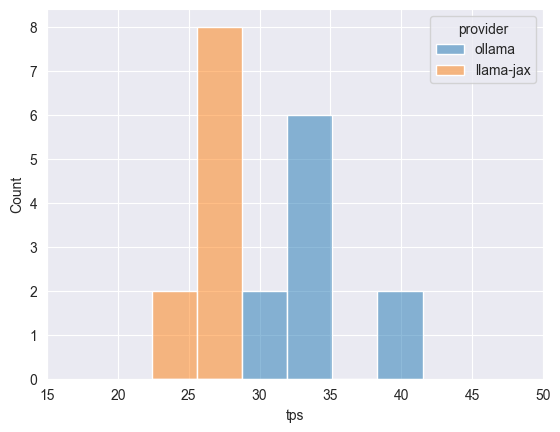

In [16]:
data = DataFrame(metrics)

ax = sns.histplot(data, x="tps", hue="provider")
ax.set_xlim(15, 50)

In [19]:
# Ollama stats
s = data[data.provider == "ollama"].tps
s.describe()

count    10.000000
mean     34.469235
std       3.240649
min      31.597827
25%      32.536482
50%      33.328804
75%      34.485886
max      41.500713
Name: tps, dtype: float64

In [20]:
# Llama Jax stats
s = data[data.provider == "llama-jax"].tps
s.describe()

count    10.000000
mean     25.778531
std       1.287958
min      22.376102
25%      25.824278
50%      26.318469
75%      26.447560
max      26.585796
Name: tps, dtype: float64